# INFO-4604/5604 HW3: Non-linear Classification 
## Deadline: Thursday, November 1, 9:00pm MT

### Solution by: *Ben Niu* (and list any partners)

## Assignment overview

In this assignment, you will perform image classification. You will experiment with support vector machines (using both linear and nonlinear kernels), as well as the two nonlinear algorithms we discussed recently, decision trees and multilayer perceptron.

The data for this assignment comes from [CIFAR-10](http://www.cs.utoronto.ca/~kriz/cifar.html), an image dataset created at the University of Toronto. Images are labeled with one of 10 classes (see examples below). Some of the classes are similar (e.g., "automobile" and "truck"), though in this dataset, they are defined to be mutually exclusive.

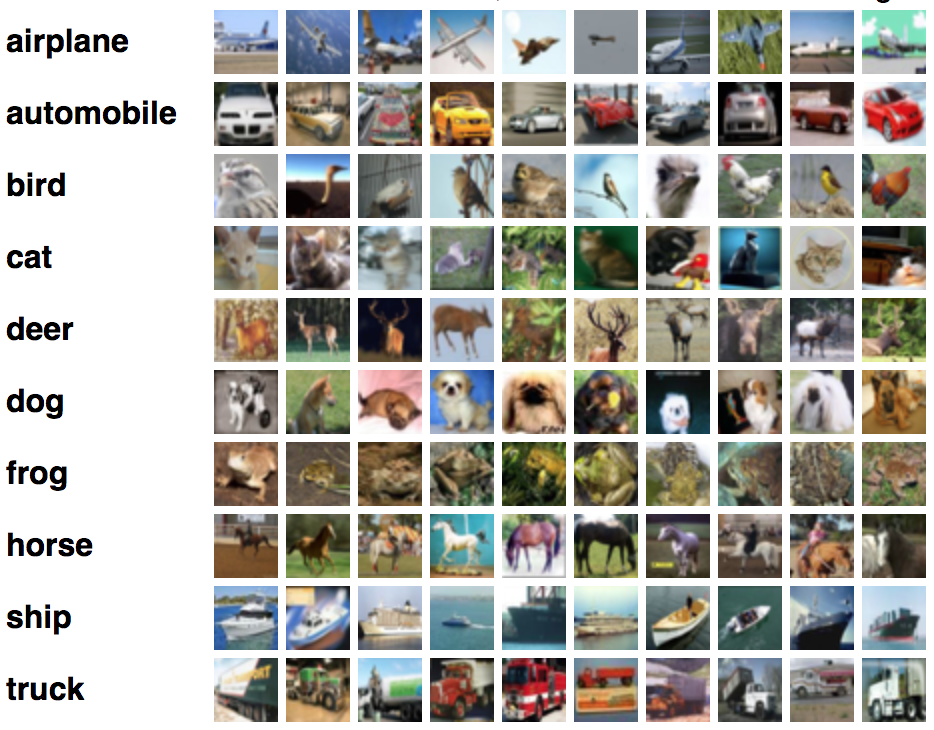

In [1]:
from IPython.display import Image
Image('http://cmci.colorado.edu/classes/INFO-4604/data/hw3_example.png', width=500) 

The images are tiny: 32x32 pixels. This makes it a difficult classification problem, because there is not a lot of detail in the images, but this is actually convenient for the purpose of this assignment, because the small size makes the data easier to work with computationally.

In general, image classification is a challenging machine learning problem, as well as a computationally intensive one. How to define and extract good features is an open challenge $-$ you'll see a little of that here. The CIFAR-10 data contains 50,000 images for training and 10,000 for testing, but for this assignment, you will work with only a sample of 5,000 training images and 2,000 test images. Your classifiers won't be as accurate as classifiers trained on all 50,000 instances, but it will be a lot more manageable to work with a small sample.


### What to hand in

You will submit the assignment on Canvas. Submit a single Jupyter notebook named `hw3lastname.ipynb`, where lastname is replaced with your last name.

If you have any output that is not part of your notebook, you may submit that as a separate document, in a single PDF named `hw3lastname.pdf`. For example, this assignment requires you to create plots. You could do it directly with python using [matplotlib](https://matplotlib.org/), but if you wanted to create them using other software, that's acceptable as long as you put all of the figures in a single document and you clearly label them with the corresponding deliverable number.

When writing code in this notebook, you are encouraged to create additional cells in whatever way makes the presentation more organized and easy to follow. You are allowed to import additional Python libraries.

### Submission policies

- **Collaboration:** You are allowed to work with up to 3 people besides yourself. You are still expected to write up your own solution. Each individual must turn in their own submission, and list your collaborators after your name.
- **Late submissions:** We allow each student to use up to 5 late days over the semester. You have late days, not late hours. This means that if your submission is late by any amount of time past the deadline, then this will use up a late day. If it is late by any amount beyond 24 hours past the deadline, then this will use a second late, and so on. Once you have used up all late days, late assignments will be given at most 80% credit after one day and 60% credit after two days.

## Getting started

Begin by downloading and loading the data, stored in CSV format. The first column in each CSV file is the class label (the $y$ value), and the remaining columns are the feature values. The [`StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class is used to standardize the feature values using z-score normalization.

It may take a minute to run the cell below. In general, you'll notice that code in this assignment will take longer to execute than in HW2, even though the HW2 data had a similar number of instances and number of features. Why? The reason is that the image features are *dense*, meaning that all feature values need to be stored and used in the algorithm. In the tweets in HW2, the features were *sparse*, meaning that most of the feature values were simply $0$, and therefore didn't need to be stored in memory and in many cases could be skipped during computation in the learning algorithms.

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()

print('Loading training data...')

df = pd.read_csv('http://cmci.colorado.edu/classes/INFO-4604/data/cifar_raw_train.csv', header=None)

rawY = df.iloc[0:, 0].values
rawX = df.iloc[0:, 1:].values
scalar.fit(rawX)
rawX = scalar.transform(rawX)

print('...done.')
print('Loading test data...')

df = pd.read_csv('http://cmci.colorado.edu/classes/INFO-4604/data/cifar_raw_test.csv', header=None)

rawY_test = df.iloc[0:, 0].values
rawX_test = df.iloc[0:, 1:].values
scalar.fit(rawX_test)
rawX_test = scalar.transform(rawX_test)

print('...done.')


Loading training data...


D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


...done.
Loading test data...
...done.


### What do the columns mean?

The columns in the above CSV files correspond to color values of each pixel of the image (after the first column, which is the label). A 32x32 image has 1,024 pixels. The first 1,024 features are the red channel values of each pixel (values from 0 to 255), the second 1,024 features are the green channel values, and the last 1,024 features are the blue channel values, for a total of 3,072 features.

We refer to this as the "raw" data, because it simply encodes the image itself. You will load a different version of the dataset with more abstract features later on in this notebook.

### Establishing a baseline

Before experimenting with building classifiers, it can be good to come up with a "baseline" accuracy that you expect your classifiers to outperform. This is helpful for contextualizing how good your classifiers are doing.

`sklearn` provides a class called [`DummyClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) which implements a few different naive baselines that don't learn from features. In the code below, we use the `most_frequent` strategy, which simply creates a classifier that always predicts the majority class in the training data.

The ten classes in this dataset are roughly evenly distributed, so the majority class baseline only has an accuracy of 10%. If you get an accuracy of 10% or lower in your experiments later, you'll know that your classifier is not learning anything useful.

In [3]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

classifier = DummyClassifier(strategy='most_frequent')
classifier.fit(rawX, rawY)

print("Training accuracy: %0.6f" % accuracy_score(rawY, classifier.predict(rawX)))
print("Testing accuracy: %0.6f" % accuracy_score(rawY_test, classifier.predict(rawX_test)))

Training accuracy: 0.104000
Testing accuracy: 0.108500


## Problem 1: Support vector machines

We will begin by trying to classify the data using support vector machines (SVMs). For this problem, you will use `sklearn`'s [`SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) class, which implements a variety of SVM kernels. To handle multiple classes, `SVC` uses the "all pairs" algorithm (called "one-vs-one" in the `sklearn` documentation) for multiclass classification. (In contrast, the `SGDClassifier` you used in HW2 uses "one-vs-rest" by default, so you may get different results if you try to compare the two.)

You can define the kernel with the `kernel` keyword argument. Additional keyword arguments can specify various hyperparameters specific to the kernels. You should try four different kernels:

- `linear`
- `poly` with `degree=2` (a quadratic kernel)
- `poly` with `degree=3` (a 3rd-degree polynomial kernel)
- `rbf` (the radial basis function or Gaussian kernel)

You should also set the hyperparameter $C$ with the keyword argument `C`, which controls the tradeoff between regularization (increasing the margin) and training performance (decreasing the loss). `C` is similar to `alpha` in `SGDClassifier`, but the inverse: increasing `alpha` increases regularization, while increasing `C` decreases regularization.

### Classifying the raw data [2 points]

Let's start by using the data described above, which contains 3,072 features representing the RGB color values of the 1,024 pixels in the 32x32 images.

While the data was already downsampled to 5,000 training instances, it still takes a minute to train an SVM on this data. To speed things up while starting out, you should instead use only the first 1,000 training instances. This is already done in the code for you in the first block, which you can use as a starting point, where `rawX[:1000]` and `rawY[:1000]` are selecting the first 1000 entries of those arrays. (The dataset of 5,000 was already sorted in random order, so taking the first 1,000 rather than a random 1,000 will not bias the data distribution.)

#### Deliverable 1.1: For each of the four kernels listed above, calculate the training and test accuracy when setting `C` to each of $[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]$. Fill out the table below, where for each kernel you give the value of $C$ that gave the best test accuracy, as well as the test accuracy itself at that value of $C$.

| Kernel | $C$ | Test accuracy | 
|--------|-----|---------------|
| Linear | 0.0001|     0.32        | 
| Poly-2 |1000|        0.26       | 
| Poly-3 |  1000   |    0.25           | 
| RBF    |  1.0   | 0.36              |

In [15]:
from sklearn.svm import SVC

# code for 1.1 here

# Note the random_state argument. Like in HW2, you should keep this argument
# in every classifier constructor so that you get consistent results.
c = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]

for i in c:
    classifier = SVC(kernel='rbf', C=i, random_state=123)
    classifier.fit(rawX[:1000], rawY[:1000])

    print("Training accuracy: %0.6f" % accuracy_score(rawY[:1000], classifier.predict(rawX[:1000])))
    print(i)
    print("Test accuracy: %0.6f" % accuracy_score(rawY_test, classifier.predict(rawX_test)))

Training accuracy: 0.112000
0.0001
Test accuracy: 0.099000
Training accuracy: 0.112000
0.001
Test accuracy: 0.099000
Training accuracy: 0.112000
0.01
Test accuracy: 0.099000
Training accuracy: 0.253000
0.1
Test accuracy: 0.211500
Training accuracy: 0.776000
1.0
Test accuracy: 0.360000
Training accuracy: 0.999000
10.0
Test accuracy: 0.359000
Training accuracy: 1.000000
100.0
Test accuracy: 0.358000
Training accuracy: 1.000000
1000.0
Test accuracy: 0.358000


### Using better features [4 points]

Using the color values of each individual pixel typically does not yield good image classification results. The exact color value of a specific pixel is not likely to be associated with a specific class in a way that generalizes well. Typically, more general and abstract features are extracted from images before using them in learning algorithms.

For the remainder of this assignment, we will use a different, preprocessed version of the dataset containing various image features rather than the original pixel representation. The data has two broad types of features:

- *DAISY* is an algorithm for extracting "descriptors" of different parts of an image, such as edges. These features were extracted using [scikit-image](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.daisy).
- *Color histograms* provide counts of the number of times ranges of colors appear within an image (or section of an image), providing a summary of the color distribution rather than specifying the colors of individual pixels. For this data, color histogram features are extracted from the entire image as well as each quadrant of the image. These features were extracted using the `calcHist` function of the [OpenCV](https://opencv.org/) computer vision library.

To load the new data, run the block of code below:

In [6]:
scalar = StandardScaler()

print('Loading training data...')

df = pd.read_csv('http://cmci.colorado.edu/classes/INFO-4604/data/cifar_features_train.csv', header=None)

Y = df.iloc[0:, 0].values
X = df.iloc[0:, 1:].values
scalar.fit(X)
X = scalar.transform(X)

print('...done.')
print('Loading test data...')

df = pd.read_csv('http://cmci.colorado.edu/classes/INFO-4604/data/cifar_features_test.csv', header=None)

Y_test = df.iloc[0:, 0].values
X_test = df.iloc[0:, 1:].values
scalar.fit(X_test)
X_test = scalar.transform(X_test)

print('...done.')

Loading training data...
...done.
Loading test data...
...done.


<br /><br />


#### Deliverable 1.2: Redo the experiments you did for 1.1 using the data with new features. Fill in the table below, once again with the best test accuracies and the $C$ values that gave those accuracies:

| Kernel | $C$ | Test accuracy | 
|--------|-----|---------------|
| Linear |  0.001   |    0.42           | 
| Poly-2 |   1000  |     0.376          | 
| Poly-3 |    10 |        0.295       | 
| RBF    |   1  |         0.447      |

#### Deliverable 1.3: Compare the results from 1.2 to the results from 1.1. Comment on three aspects: (i) Overall, which version (raw data in 1.1 or preprocessed data in 1.2) resulted in better performance? (ii) Was the relative performance of the four kernels (e.g., `rbf` outperforms `linear`) similar across the two versions? (iii) Were the optimal $C$ values similar across the two versions?

[response here]
(i)1.2 version raw data resulted in better performance
(ii) The relative performance of the four kernels are not similar across the two versions
(iii)the optimal C values are not similar across the two versions.

In [19]:
# code for 1.2 here
c = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
for i in c:
    classifier = SVC(kernel='rbf', C=i, random_state=123)
    classifier.fit(X[:1000], Y[:1000])
    print(i)
    print("Training accuracy: %0.6f" % accuracy_score(Y[:1000], classifier.predict(X[:1000])))
    print("Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

0.0001
Training accuracy: 0.112000
Test accuracy: 0.099000
0.001
Training accuracy: 0.112000
Test accuracy: 0.099000
0.01
Training accuracy: 0.112000
Test accuracy: 0.099000
0.1
Training accuracy: 0.199000
Test accuracy: 0.169500
1.0
Training accuracy: 0.901000
Test accuracy: 0.447000
10.0
Training accuracy: 1.000000
Test accuracy: 0.468000
100.0
Training accuracy: 1.000000
Test accuracy: 0.468000
1000.0
Training accuracy: 1.000000
Test accuracy: 0.468000


<br /><br />

### Understanding kernels [8 points]

Above, we only used the first 1000 training instances (out of 5000) for the sake of speed. Now let's vary the amount of training data by changing the `1000` in `X[:1000]` and `Y[:1000]` to other values.

For these experiments, let's focus on the `rbf` kernel (which you should have found outperformed the others) and the `linear` kernel. Set `C` to $0.001$ for the linear kernel and $10.0$ for the RBF kernel. Use the preprocessed data rather than the raw data (i.e., `X` and `Y` instead of `rawX` and `rawY`).

#### Deliverable 1.4: Train a linear and RBF kernel classifier using the first $N$ training instances (where $N=1000$ in the earlier problems) when $N$ is each of $[20, 50, 100, 200, 400, 800, 1500, 3000, 5000]$ and calculate the test accuracy. Create a line plot where the x-axis is $N$ and the y-axis is test accuracy. There should be two lines, one for each kernel.

[your solution should either be plotted below, or included in a separate PDF]

#### Deliverable 1.5: Nonlinear classifiers can learn more complex patterns than linear models, but they are at higher risk of overfitting because they have more parameters to learn. Keeping this in mind, what do you observe in your plot from 1.4? What might you conclude about the advantage of nonlinear classification versus linear classification based on the size of the training data?

[response here]
As size of training data N incresing, both nonlinear classification and linear classification are incresing the accuracy score. The nonlinear classification has the higher accuracy score.


In [22]:
# code for 1.4 here
N = [20,50,100,200,400,800,1500,3000,5000]
testac = []

for i in N:
    classifier = SVC(kernel='rbf', C=10, random_state=123)
    classifier.fit(X[:i], Y[:i])
    testac.append(accuracy_score(Y_test, classifier.predict(X_test)))
    print(i)
    #print("Training accuracy: %0.6f" % accuracy_score(Y[:1000], classifier.predict(X[:1000])))
    print("Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))
    


20
Test accuracy: 0.120000
50
Test accuracy: 0.224000
100
Test accuracy: 0.247500
200
Test accuracy: 0.337000
400
Test accuracy: 0.397000
800
Test accuracy: 0.436000
1500
Test accuracy: 0.482500
3000
Test accuracy: 0.545000
5000
Test accuracy: 0.579000


In [24]:
lineartestac= []
for i in N:
    classifier = SVC(kernel='linear', C=0.001, random_state=123)
    classifier.fit(X[:i], Y[:i])
    lineartestac.append(accuracy_score(Y_test, classifier.predict(X_test)))
    print(i)
    #print("Training accuracy: %0.6f" % accuracy_score(Y[:1000], classifier.predict(X[:1000])))
    print("LINEARTest accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

20
LINEARTest accuracy: 0.141500
50
LINEARTest accuracy: 0.236500
100
LINEARTest accuracy: 0.248000
200
LINEARTest accuracy: 0.331000
400
LINEARTest accuracy: 0.375500
800
LINEARTest accuracy: 0.420500
1500
LINEARTest accuracy: 0.453000
3000
LINEARTest accuracy: 0.494500
5000
LINEARTest accuracy: 0.539000


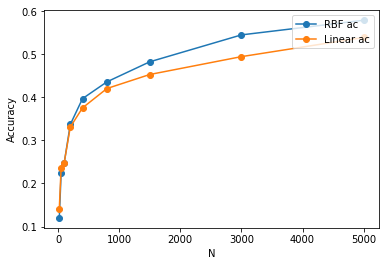

In [25]:
import matplotlib.pyplot as plt
#plt.plot(alpha, actrain,actest, marker='o')
plt.plot(N,testac,marker='o',label='RBF ac')
plt.plot(N,lineartestac,marker='o',label='Linear ac')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

plt.show()

<br /><br />

In class, we learned that the RBF kernel has a hyperparameter $\gamma$ which can affect overfitting. You can set the value of $\gamma$ with the keyword argument `gamma`.

For these experiments with `gamma`, it is preferred that you use all 5000 training instances, though if it is too slow, it is acceptable to use 1000 instances.

#### Deliverable 1.6: Train an RBF SVM (with $C=10.0$) where `gamma` is each of: [`1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`, `1e-7`], where `1eM` is scientific notation meaning $1 \times 10^M$. For each value of `gamma`, compute both the training accuracy and test accuracy. Record the values in the table below:

| `gamma` | Training accuracy | Test accuracy | 
|--------|--------------------|---------------|
| `1e-2` |       1.0             |     0.099          | 
| `1e-3` |       1.0             |      0.4485         | 
| `1e-4` |       0.949             |     0.455          | 
| `1e-5` |        0.559            |      0.406         |
| `1e-6` |       0.165             |      0.135         | 
| `1e-7` |       0.112             |      0.099         | 

#### Deliverable 1.7: Describe what you observe in the table for 1.6, describing the effect of `gamma` in terms of the bias/variance tradeoff.

[response here]
For general, the smaller the value of gamma, the lower the training accuracy and test accuracy

In [30]:
# code for 1.6 here
g = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

for i in g:
    classifier = SVC(kernel='rbf', C=10, random_state=123,gamma = i)
    classifier.fit(X[:1000], Y[:1000])
    print(i)
    print("Training accuracy: %0.6f" % accuracy_score(Y[:1000], classifier.predict(X[:1000])))
    print("Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))
    


0.01
Training accuracy: 1.000000
Test accuracy: 0.099000
0.001
Training accuracy: 1.000000
Test accuracy: 0.448500
0.0001
Training accuracy: 0.949000
Test accuracy: 0.455500
1e-05
Training accuracy: 0.559000
Test accuracy: 0.406000
1e-06
Training accuracy: 0.165000
Test accuracy: 0.135500
1e-07
Training accuracy: 0.112000
Test accuracy: 0.099000


<br />

### Understanding features [5604: 4 points; 4604: +2 EC]

As stated earlier, there are two types of features in the preprocessed data: DAISY features and color histogram features. 

For this last SVM problem, create two additional copies of `X` and `X_test`: one that only contains the DAISY features (the first $1664$ columns of `X`), and one that only contains the histogram features (the last $320$ columns of `X`). Give the copies new variable names, because the rest of this notebook will continue to use the previous definitions of `X` and `X_test`.

Experiment with these two different feature sets. For these experiments, use a linear SVM with $C=0.001$ and an RBF SVM with $C=10.0$.

#### Deliverable 1.8: Compute the test accuracy when using only the DAIRY features (for both linear and RBF kernels), and compute the test accuracy when using only histogram features (for both kernels). Describe what you observe. How do the two feature sets compare to each other? How do the two feature sets compare to using both types of features combined? 

[response here]
The linear model has higher test accuracy but lower training accuracy when comparing to the RBF model. It has a similar test accuracy with using both types of features combined in 1000 size dataset. 

In [22]:
# code for 1.8 here
Xec= X[:1664]
Xectest = X[-320:]
Yec=Y[:1664]
Yectest=Y[-320:]
classifier = SVC(kernel='rbf', C=10, random_state=123)
classifier.fit(Xec, Yec)

print("Training accuracy: %0.6f" % accuracy_score(Yec, classifier.predict(Xec)))
print("Test accuracy: %0.6f" % accuracy_score(Yectest, classifier.predict(Xectest)))
    

Training accuracy: 1.000000
Test accuracy: 0.468750


In [23]:
classifier = SVC(kernel='linear', C=0.001, random_state=123)
classifier.fit(Xec, Yec)

print("Training accuracy: %0.6f" % accuracy_score(Yec, classifier.predict(Xec)))
print("Test accuracy: %0.6f" % accuracy_score(Yectest, classifier.predict(Xectest)))

Training accuracy: 0.714543
Test accuracy: 0.487500




## Problem 2: Decision Trees [6 points]

Let's now experiment with decision tree classification on the preprocessed data using `sklearn`'s [`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) class.

There are a variety of hyperparameters that can be adjusted to control the bias/variance tradeoff. We will experiment with two:

- `max_depth` is the maximum depth of the decision tree, as we learned about in class.
- `min_samples_leaf` is the minimum number of training instances that must be remaining at a leaf node to make a final prediction. If the algorithm tries to split a node and fewer than this minimum instances would end up in the leaf, then the algorithm will stop expanding down that path.

As with SVMs, a bit of code is in the cell below to help you get started.


#### Deliverable 2.1: Experiment with setting `max_depth` to each of $[3, 8, 14, 100]$ and setting `min_samples_leaf` to each of $[1, 5, 10, 15, 50]$. For each combination of these two hyperparameters, record the training and test accuracies in the large table below. It will take a few minutes to do all of these combinations. It is preferred that you use all 5000 training instances, though if it is too slow, it is acceptable to use 1000 instances.

| `max_depth` | `min_samples_leaf` | Training accuracy | Test accuracy | 
|-------------|--------------------|-------------------|---------------|
| $3$         |   $1$              |        0.2902           |     0.27          |
| $3$         |   $5$              |         0.2902          |     0.27          |
| $3$         |   $10$             |         0.2902          |      0.27         |
| $3$         |   $15$             |         0.2902          |      0.27         |
| $3$         |   $50$             |         0.2902          |      0.27         |
| $8$         |   $1$              |         0.5504          |      0.3275         |
| $8$         |   $5$              |         0.538          |       0.3335        |
| $8$         |   $10$             |         0.519          |       0.3331        |
| $8$         |   $15$             |         0.513          |       0.334        |
| $8$         |   $50$             |         0.443          |       0.33        |
| $14$        |   $1$              |         0.926          |       0.291        |
| $14$        |   $5$              |         0.768          |       0.291        |
| $14$        |   $10$             |         0.648          |       0.313        |
| $14$        |   $15$             |         0.595          |       0.315        |
| $14$        |   $50$             |         0.451          |       0.328        |
| $100$       |   $1$              |         1.0          |         0.293      |
| $100$       |   $5$              |         0.783          |       0.2935        |
| $100$       |   $10$             |         0.6524          |      0.312         |
| $100$       |   $15$             |         0.595          |       0.315        |
| $100$       |   $50$             |         0.451          |       0.328        |

#### Deliverable 2.2: Based on your observations, as well as what you know about these two hyperparameters, describe the effects of `max_depth` and `min_samples_leaf` on the classifier performance and bias/variance tradeoff, including anything you observe about particular combinations of the two hyperparameters.

[response here]
In general, the trend is the higher the max depth and the min_sample leaf, the higher the training and test accuracy. 


<br />

It seems decision trees do not perform especially well on this dataset. In class, we learned that *random forests* can combine a number of different decision trees to improve performance. This is easy to run in `sklearn` with the [`RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) class. It uses most of the arguments that `DecisionTreeClassifier` supports. The argument `n_estimators` specifies the number of decision trees to train.

#### Deliverable 2.3: Train a random forest using the best settings of `max_depth` and `min_samples_leaf` from 2.1 and record the test accuracies in the table below. Set `n_estimators` to each of $[10, 50, 100, 300]$. You should see a substantial increase in accuracy over using an individual decision tree.

| `n_estimators` | Test accuracy | 
|----------------|---------------|
| $10$           |      0.35         |
| $50$           |      0.4545         |
| $100$          |      0.49         |
| $300$          |      0.506         |

In [33]:
from sklearn.tree import DecisionTreeClassifier

# code for 2.1 here
ma = [3,8,14,100]
mi = [1,5,10,15,50]

for i in ma:
    for g in mi:
        classifier = DecisionTreeClassifier(max_depth=i, min_samples_leaf=g, random_state=123)
        classifier.fit(X[:5000], Y[:5000])
        print(i,g)
        print("Training accuracy: %0.6f" % accuracy_score(Y[:5000], classifier.predict(X[:5000])))
        print("Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

3 1
Training accuracy: 0.290200
Test accuracy: 0.270000
3 5
Training accuracy: 0.290200
Test accuracy: 0.270000
3 10
Training accuracy: 0.290200
Test accuracy: 0.270000
3 15
Training accuracy: 0.290200
Test accuracy: 0.270000
3 50
Training accuracy: 0.290200
Test accuracy: 0.270000
8 1
Training accuracy: 0.550400
Test accuracy: 0.327500
8 5
Training accuracy: 0.538000
Test accuracy: 0.333500
8 10
Training accuracy: 0.519600
Test accuracy: 0.331000
8 15
Training accuracy: 0.513400
Test accuracy: 0.334500
8 50
Training accuracy: 0.443800
Test accuracy: 0.330000
14 1
Training accuracy: 0.926600
Test accuracy: 0.291500
14 5
Training accuracy: 0.768600
Test accuracy: 0.291000
14 10
Training accuracy: 0.648800
Test accuracy: 0.313500
14 15
Training accuracy: 0.595600
Test accuracy: 0.315500
14 50
Training accuracy: 0.451400
Test accuracy: 0.328000
100 1
Training accuracy: 1.000000
Test accuracy: 0.293000
100 5
Training accuracy: 0.783800
Test accuracy: 0.293500
100 10
Training accuracy: 0.65

In [36]:
from sklearn.ensemble import RandomForestClassifier

# code for 2.3 here
n = [10,50,100,300]
for i in n:
    classifier = RandomForestClassifier(n_estimators=i, max_depth=100, min_samples_leaf=1, random_state=123)
    classifier.fit(X[:5000], Y[:5000])
    print(i)
    print("Training accuracy: %0.6f" % accuracy_score(Y[:5000], classifier.predict(X[:5000])))
    print("Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

10
Training accuracy: 0.993800
Test accuracy: 0.359000
50
Training accuracy: 1.000000
Test accuracy: 0.454500
100
Training accuracy: 1.000000
Test accuracy: 0.490000
300
Training accuracy: 1.000000
Test accuracy: 0.506000


## Problem 3: Neural Networks

You will now experiment with building a multilayer perceptron (MLP) using `sklearn`'s [`MLPClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) class. While this algorithm has a lot of possible settings, it is actually fairly easy to get this up in running, because the class has default settings that work well in many cases. 

The most important setting to adjust is the number of hidden layers and the number of units in each hidden layer. This can be adjusted with the `hidden_layer_sizes` which takes a tuple of integers as its value. For example, `hidden_layer_sizes=(50)` indicates one hidden layer with 50 units; `hidden_layer_sizes=(100,10)` indicates two hidden layers with 100 units in the first and 10 units in the second.

### MLP classification [6 points]

#### Deliverable 3.1: Compute the test accuracy when training an MLP with one hidden layer containing each of $[50, 100, 200, 300]$ units. Then train an MLP with two hidden layers, where the first layer has $[50, 100, 200, 300]$ units and the second layer has $[20, 50, 100, 200]$ units. Record the accuracies in the table below. It will take a few minutes to do all of these combinations. It is preferred that you use all 5000 training instances, though if it is too slow, it is acceptable to use 1000 instances.

| 1st layer | 2nd layer | Test accuracy |
|-----------|-----------|---------------|
| $50$      | none      |    0.5175           |
| $100$     | none      |    0.5175           |
| $200$     | none      |    0.5175           |
| $300$     | none      |    0.5175           |
| $50$      | $20$      |    0.511           |
| $50$      | $50$      |    0.533           |
| $50$      | $100$     |    0.523           |
| $50$      | $200$     |    0.541           |
| $100$     | $20$      |    0.536           |
| $100$     | $50$      |    0.538           |
| $100$     | $100$     |    0.561           |
| $100$     | $200$     |    0.547           |
| $200$     | $20$      |    0.54           |
| $200$     | $50$      |    0.5535           |
| $200$     | $100$     |    0.5615           |
| $200$     | $200$     |    0.558           |
| $300$     | $20$      |    0.544           |
| $300$     | $50$      |    0.549           |
| $300$     | $100$     |    0.581           |
| $300$     | $200$     |    0.563           |


<br />

It can be helpful to understand what types of mistakes a classifier is making. This is often visualized with the classifier's *confusion matrix*. A confusion matrix is a $K \times K$ array (where $K$ is the number of classes) which displays how many times an instance of one class was classified as another. Specifically, the value in row $i$ and column $j$ is the number of instances whose true class is $i$ and predicted class is $j$. 

The confusion matrix can be computed with the [`confusion_matrix`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function. This function takes the same input as `accuracy_score` $-$ the first argument is the array of correct labels, and the second argument is the array of labels predicted by the classifier.

Note that the labels in this dataset are encoded as integers from $0$ to $9$. In the code below, the `label_names` list defines a mapping from integers to human-readable class names.

#### Deliverable 3.2: Using the best setting of `hidden_layer_sizes` from 3.1, train an MLP and compute the confusion matrix from the test data. For each class, determine the class that was most commonly predicted for it (except itself); in other words, the most common error for each class. Record the labels in the table below.

| Correct class | Most common wrong prediction     |
|---------------|----------------------------------|
| airplane      |          bird                        |
| automobile    |          truck                        |
| bird          |          deer                        |
| cat           |           dog                       |
| deer          |          bird                       |
| dog           |           cat                       |
| frog          |           cat                       |
| horse         |           deer                      |
| ship          |            airplane                       |
| truck         |            ship                      |

#### Deliverable 3.3: What do you observe in the confusion matrix and the table from 3.2? Which types of classes does the classifier most often confuse? Why do you think this happens?

[response here]
The error rate are still big for each class predicted, the animal class especically, the cat, bird,and deer most often confused. Maybe they have more features that are similar to other class. 

In [40]:
# code for 3.1 here
from sklearn.neural_network import MLPClassifier
n = [50,100,200,300]
s = [20,50,100,200]
for i in n:
    for g in s:
        classifier = MLPClassifier(hidden_layer_sizes= (i,g) , random_state=123)
        classifier.fit(X[:5000], Y[:5000])
        print(i,g)
        #print("Training accuracy: %0.6f" % accuracy_score(Y[:5000], classifier.predict(X[:5000])))
        print("Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

50 20
Test accuracy: 0.511000
50 50
Test accuracy: 0.533000
50 100
Test accuracy: 0.523000
50 200
Test accuracy: 0.541000
100 20
Test accuracy: 0.536500
100 50
Test accuracy: 0.538000
100 100
Test accuracy: 0.561000
100 200
Test accuracy: 0.547000
200 20
Test accuracy: 0.540000
200 50
Test accuracy: 0.553500
200 100
Test accuracy: 0.561500
200 200
Test accuracy: 0.558000
300 20
Test accuracy: 0.544000
300 50
Test accuracy: 0.549500
300 100
Test accuracy: 0.581000
300 200
Test accuracy: 0.563500


In [52]:
from sklearn.metrics import confusion_matrix

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# code for 3.2 here
classifier = MLPClassifier(hidden_layer_sizes= (300,100) , random_state=123)
classifier.fit(X[:5000], Y[:5000])
       
        #print("Training accuracy: %0.6f" % accuracy_score(Y[:5000], classifier.predict(X[:5000])))
print("Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))
Y_pred = classifier.predict(X_test)

print(confusion_matrix(Y_test, Y_pred))



Test accuracy: 0.581000
[[122   9  13   1   8   1   3   4  27   8]
 [  7 140   5   4   4   3   3   1  22   9]
 [ 26   0  81  10  29  16  17   9   4   3]
 [  6   8  22  59  16  36  21  16   3  12]
 [  2   3  25  14  94  14  19  21   3   3]
 [  4   0  17  29  13  89  15  13   0   5]
 [  2   1   9  11  18   6 156   7   1   5]
 [  5   1   6   8  14  12   5 128   2  12]
 [ 20  18   5   3   1   1   2   1 153  13]
 [  3  24   8   6   1   0   2   3  16 140]]


### Improving the classifier [optional: +2 EC]

It is possible to tune the MLP classifier to get better test accuracy than any of the results in 3.1. Experiment with different hyperparameter settings and see if you can improve the performance.

#### Deliverable 3.4: Find a different setting of hyperparameters (for example,  `hidden_layer_sizes`) that improves test accuracy.

[response here]
400,300


In [11]:
scalar = StandardScaler()

print('Loading training data...')

df = pd.read_csv('http://cmci.colorado.edu/classes/INFO-4604/data/cifar_features_train.csv', header=None)

Y = df.iloc[0:, 0].values
X = df.iloc[0:, 1:].values
scalar.fit(X)
X = scalar.transform(X)

print('...done.')
print('Loading test data...')

df = pd.read_csv('http://cmci.colorado.edu/classes/INFO-4604/data/cifar_features_test.csv', header=None)

Y_test = df.iloc[0:, 0].values
X_test = df.iloc[0:, 1:].values
scalar.fit(X_test)
X_test = scalar.transform(X_test)

print('...done.')

Loading training data...
...done.
Loading test data...
...done.


In [13]:
# code for 3.4 (optional extra credit) goes here
from sklearn.neural_network import MLPClassifier
nec = [300,350,400,450,500,600]
sec = [20,50,100,200,300]
for i in nec:
    for g in sec:
        classifier = MLPClassifier(hidden_layer_sizes= (i,g) , random_state=123)
        classifier.fit(X[:5000], Y[:5000])
        print(i,g)
        #print("Training accuracy: %0.6f" % accuracy_score(Y[:5000], classifier.predict(X[:5000])))
        print("Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

300 20
Test accuracy: 0.544000
300 50
Test accuracy: 0.549500
300 100
Test accuracy: 0.581000
300 200
Test accuracy: 0.563500
300 300
Test accuracy: 0.577000
350 20
Test accuracy: 0.557000
350 50
Test accuracy: 0.559500
350 100
Test accuracy: 0.574000
350 200
Test accuracy: 0.573500
350 300
Test accuracy: 0.569500
400 20
Test accuracy: 0.552500
400 50
Test accuracy: 0.555500
400 100
Test accuracy: 0.568500
400 200
Test accuracy: 0.564000
400 300
Test accuracy: 0.585000
450 20
Test accuracy: 0.572000
450 50
Test accuracy: 0.564000
450 100
Test accuracy: 0.576000
450 200
Test accuracy: 0.574000
450 300
Test accuracy: 0.571000
500 20
Test accuracy: 0.555500
500 50
Test accuracy: 0.576500
500 100
Test accuracy: 0.576500
500 200
Test accuracy: 0.571000
500 300
Test accuracy: 0.588000
600 20
Test accuracy: 0.562000
600 50
Test accuracy: 0.566000
600 100
Test accuracy: 0.576500
600 200
Test accuracy: 0.574500
600 300
Test accuracy: 0.580000
